<a href="https://colab.research.google.com/github/amnnsharma/GlidePro/blob/main/VLP_Modified.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
from scipy.interpolate import interp1d
import numpy as np

def c_to_f(c):
    return 9 / 5 * float(c) + 32


def f_to_c(f):
    return (float(f) - 32) * 5 / 9


def kg_to_psi(kg):
    return float(kg) * 14.2233


def psi_to_kg(psi):
    return float(psi) * 14.2233


def api_to_sg_oil(api):
    return 141.5 / (131.5 + api)


def sg_oil_to_api(sg_oil):
    return 141.5 / sg_oil - 131.5


##############WATER PROPERTIES####################
def water_volume_factor(p, t):
    tx = t - 60
    return 1 + 1.21 * 10**-4 * tx + 10**-6 * tx**2 - 3.33 * 10**-6 * p


##############CRUDE OIL PROPERTIES##################


def bubble_point(p,sg_oil, sg_gas, temp, glr):
    rb=solution_gor(p,sg_oil,sg_gas,temp, glr)
    api=sg_oil_to_api(sg_oil)
    y = 0.00091 * temp - 0.0125 * api
    # Rb (solution gor) is in scf/stb
    pb = 18 * math.pow(rb / sg_gas, 0.83) * math.pow(10, y)
    return pb




def solution_gor(p, sg_oil, sg_gas, temp, glr):
    api=sg_oil_to_api(sg_oil)
    y = 0.00091 * temp - 0.0125 * api
    rs = sg_gas * math.pow(p / 18 / math.pow(10, y), 1.205)
    return min(rs,glr)    #480 in example for bottomhole point



def crude_volume_factor(p, sg_gas, sg_oil, temp, glr):
    rs=solution_gor(p, sg_oil, sg_gas, temp, glr)
    #print("RS",rs)
    f = rs * (sg_gas / sg_oil)**0.5 + 1.25 * temp
    bo = 0.972 + 1.47 * 10**-4 * f**1.175
    return bo




def oil_viscocity(rs, dead_viscosity):
    A = 0.2 + 0.8 * 10 ** (-0.0081 * rs)
    b = 0.43 + 0.57 * 10 ** (-0.00072 * rs)
    return A * dead_viscosity**b



###########GAS PROPERTIES###############

def gas_volume_factor(p, t, sg_gas):
    z=z_factor(sg_gas, p, t)
    return 0.0283 * z * (t + 460) / p


def gas_density(sg_gas, p, t):
    z=z_factor(sg_gas,p, t)
    return 2.7 * sg_gas * p / z / (t + 460)


def z_factor(sg_gas, p, t, A=0, B=0):
    pc = 709.6 - 58.7 * sg_gas
    tc = 170.5 + 307.3 * sg_gas
    e = 120 * (A**0.9 - A**1.6) + 15 * (B**0.5 - B**4)
    tm = tc - e
    pm = pc * (tm / (tc + B * (1 - B) * e))
    pr = p / pm
    tr = (t + 460) / tm
    z = 1 - 3.52 * pr / (10 ** (0.9813 * tr)) + 0.274 * pr**2 / (10 ** (0.8157 * tr))
    return z


def gas_viscocity(sg_gas, p, t):
    z=z_factor(sg_gas,p,t)
    m = 29 * sg_gas
    k = (9.4 + 0.02 * m) * (t + 460) ** 1.5 / (209 + 19 * m + t + 460)
    x = 3.5 + 986 / (t + 460) + 0.01 * m
    y = 2.4 - 0.2 * x
    rho_g = 0.0433 * sg_gas * p / z / (t + 460)
    return 0.00001 * k * math.e ** (x * rho_g**y)


########MULTIPHASE FLOW CORRELATION#########

def constant_pi(q, pwf, pr):
    return q / (pr - pwf)


def vogel_aofp(q, pwf, pr):
    return q / (1 - 0.2 * pwf / pr - 0.8 * pwf**2 / pr**2)


def gas_annulus_pressure(
    depth,
    surface_pressure,
    sg_gas,
    t1,
    t2,
):
    divisions = 10
    depths = np.linspace(0, depth, divisions)
    p = [surface_pressure]
    for d in depths:
        tavg = ((t2 - t1) / depth * d + 2 * t1) / 2 + 460
        if len(p) < 2:
            pavg = p[-1]
        else:
            pavg = (p[-1] + p[-2]) / 2
        zavg = z_factor(sg_gas, pavg, tavg)
        k = 0.01877 * sg_gas * depth / divisions / zavg / tavg
        p.append(p[-1] * math.e ** (0.01877 * sg_gas * depth / divisions / zavg / tavg))

    return p



##########WITH WATER, OIL AND GAS####################


def multiphase_velocities_and_densities(
    ql, glr, wor, p, t, d, sg_gas, sg_oil, sg_water=1.0, surf_tension=8, co=1
):
    ap = math.pi * d**2 / 4 / 144
    api = sg_oil_to_api(sg_oil)
    rs = solution_gor(p, sg_oil, sg_gas, t, glr)
    bo = crude_volume_factor(p, sg_gas, sg_oil, t, glr)
    bw = water_volume_factor(p, t)
    z = z_factor(sg_gas, p, t)
    bg = gas_volume_factor(p, t, sg_gas)

    vsl = 6.5 * 10**-5 * ql / ap * (bo / (1 + wor) + bw * wor / (1 + wor))

    vsg = 1.16 * 10**-5 * ql / ap * (glr - rs / (1 + wor)) * bg

    rho_o = (350.4 * sg_oil + 0.076 * sg_gas * rs) / 5.61 / bo
    rho_g = 2.7 * sg_gas * p / z / (t + 460)
    rho_w = 62.5 * sg_water / bw

    rho_l = rho_w * wor / (1 + wor) + rho_o / ( 1 + wor)  ####UPDATED, if wor=0, rho_l should be equal to rho_o

    vb = 0.79 * (surf_tension * (rho_o - rho_g) / rho_o**2) ** 0.25
    eg = vsg / (co * (vsg + vsl) + vb)

    rho_m = rho_l * (1 - eg) + rho_g * eg  #THIS IS NOT USED ######DO NOT USE IT: POOR APPROXIMATION


    return vsg, vsl, rho_g, rho_l, rho_m


#######INTERPOLATION AND EXTRAPOLATION######

def fit_curve(x_data, y_data, kind='cubic'):
    interpolated_function = interp1d(x_data, y_data, kind=kind, fill_value="extrapolate")
    return interpolated_function


#########IPR###############

def ipr(q_test, p_test, pr, pb=1500 ):
    q_max_sl=q_test/(1-p_test/pr)
    if pb<pr:
        qb=(1-pb/pr)*q_test/(1-p_test/pr)
        pressure_side_test=1-0.2*pb/pr-0.8*pb**2/pr**2
        q_max_vogel=qb/pressure_side_test
    else:
        q_max_vogel=q_max_sl
    pressures=list(np.linspace(0,pr,500))[::-1]
    flow_rates=[]
    for p in pressures:
        if p<pb:
            flow_rates.append(q_max_vogel*(1-0.2*p/pr-0.8*(p/pr)**2))
        else:
            flow_rates.append(q_max_sl*(1-p/pr))

    return pressures, flow_rates

#####FRICTION FACTOR##########
def fanning_friction(d, rho_l,v_sl,mu_l):
  e=0.0002
  k=e/d
  n_re=124*rho_l*v_sl*d/mu_l
  if n_re<2300:
    f=64/n_re
  else:
    A=k**1.1098/2.8257+(7.149/n_re)**0.8981
    inverse_root_f=-2*math.log10(k/3.7065-5.0452/n_re*math.log10(A))
    f=inverse_root_f**-2
  fanning_friction_factor=f/4
  return fanning_friction_factor

####################################
#############ITERATIONS#############
####################################

def incremental_pressure(ql, glr, wc, p_surf, t_surf, t_bottom, depth, perf_depth, d, sg_gas, sg_oil, correlation, deviation_data_path, mu_l=3, surf_tension=8):
  #ql=ql*6.2898 #CONVERT TO BPD
  #glr= glr* 5.6145833 # CONVERT TO SCF/STB
  #p_surf=p_surf*14.2233  # CONVERT TO PSI
  #t_surf=t_surf*9/5+32 #CONVERT TO DEGREE F
  #depth= depth*3.28084 #CONVERT TO FEETS
  #d= d #IN INCHES
  wc=wc/100
  wor=wc/(1.0000001-wc)
  #h is taken as incremental depth from top of the well
  md, inclination=deviation_data(deviation_data_path, depth)
  iterations=len(md)-1
  h=md#list(np.linspace(0,depth,iterations))
  temp=[]
  for t in md:
    temp.append(t*(t_bottom-t_surf)/(perf_depth-md[0]))
  p=[(md[0],p_surf)]
  p_temp=p_surf
  t_temp=t_surf
  #md_temp=md[0]
  md_dp_by_dh=[]
  for i in range(iterations):
    #print(round(p,0), round(h[i],0), round(temp[i],0))
    dp_by_dh=correlation(ql, glr, wor, (p[-1][1]+p_temp)/2, (temp[i]+t_temp)/2, d, sg_gas, sg_oil)   ######SHOULD TAKE AVERAGE HERE
    md_dp_by_dh.append((md[i],dp_by_dh))
    #print(p, temp[i], dp_by_dh, fp)
    p_temp=p[-1][1]
    t_temp=temp[i]
    #print(round(dp_by_dh,3))
    p.append((md[i+1], p[-1][1] + dp_by_dh*(md[i+1]-md[i])))
    #print(dp_by_dh)

  return p, md_dp_by_dh

#incremental_pressure(ql=375, glr=480, wc=0, p_surf=346.3, t_surf=80.6, t_bottom=140.3, depth=8400, d=2.441, sg_oil=0.82, sg_gas=0.916)


##########PLOT IPR-VLP###########

import matplotlib.pyplot as plt

def plot_ipr_vlp(q_test, p_test, pr,
                 glr, wc, p_surf, t_surf, t_bottom, depth, perf_depth,
                    d, sg_gas, sg_oil, correlation, deviation_data_path, mu_l, surf_tension):

    fig, ax= plt.subplots()
    ipr_pressures, ipr_flow_rates=ipr(q_test=q_test, p_test=p_test, pr=pr)
    ax.plot(ipr_flow_rates, ipr_pressures,  linestyle='-', color='blue', alpha=0.5, label='Lines')

    flow_rates=np.linspace(min(ipr_flow_rates)+50,max(ipr_flow_rates)+200,50)
    pressures=[]
    for i in range(50):
        p, _=incremental_pressure(ql=flow_rates[i], glr=glr, wc=wc, p_surf=p_surf, t_surf=t_surf, t_bottom=t_bottom, depth=depth, perf_depth=perf_depth,
                                d=d, sg_gas=sg_gas, sg_oil=sg_oil, correlation=correlation,
                                deviation_data_path=deviation_data_path,
                                  mu_l=mu_l, surf_tension=surf_tension)
        pressures.append(p[-1][1])


    ax.plot(flow_rates, pressures,  linestyle='-', color='orange', alpha=0.5, label='Lines')


    ax.set_xlim([0,None])
    ax.set_ylim([0,None])
    plt.show()


#####DEVIATION SURVEY##########
import pandas as pd

def deviation_data(path_to_file, depth):
    #df=pd.read_csv(path_to_file)
    #md=df['md'].to_list()
    #inclination=df['inclination'].to_list()
    depths=[0,100,200,500,1000,1500,2000,3000,8000,8400]
    inclination=[90,90,90,90,90,90,90,90,90,90]

    num_points = 100
    modified_depth = np.linspace(min(depths), max(depths), num_points)

    #if depth[-1]<=depth:


    # Interpolate inclination values for the new depth values
    modified_inclination = np.interp(modified_depth, depths, inclination)

    modified_depth = modified_depth.tolist()
    modified_inclination = modified_inclination.tolist()
    depths=[]
    inclination=[]
    for i in range(len(modified_depth)):
        if modified_depth[i]<=depth:
            depths.append(modified_depth[i])
            inclination.append(modified_inclination[i])
    if depths[-1]<depth:
        depths.append(depth)
        inclination.append(inclination[-1])
    #else:
    depths.append(depths[-1])
    inclination.append(inclination[-1])

    # Print results
    #print("Modified Depth:", modified_depth)
    #print("Modified Inclination:", modified_inclination)

    #if md[-1]<=depth:
    #  md.append(depth)
    #  inclination.append(inclination[-1])

    return depths, inclination




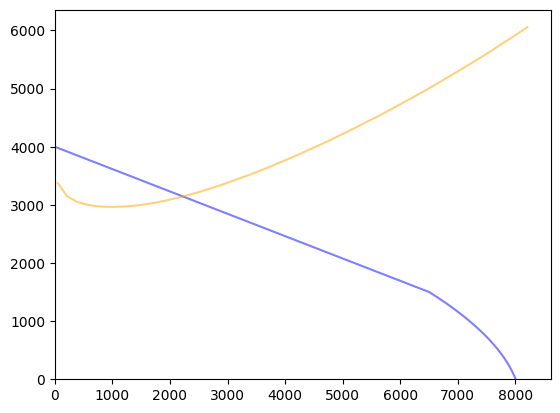

In [2]:

#from generic_functions import *

################################
#########DUNS AND ROS###########
################################

def duns_dimensionless_numbers(ql, glr, wor, p, t, d, sg_gas, sg_oil, sg_water=1.0 , surf_tension=8, co=1, mu_l=3):   #Oil Viscosity should be given actually
    vsg, vsl, _, rho_l, _= multiphase_velocities_and_densities(ql, glr, wor, p, t, d, sg_gas, sg_oil,
                                                           sg_water=1.0 , surf_tension=8, co=1)
    nlv=max(1.938*vsl*(rho_l/surf_tension)**0.25,0)
    ngv=max(1.938*vsg*(rho_l/surf_tension)**0.25,0)
    nd=max(10.1*d*(rho_l/surf_tension)**0.5,0)
    nl=max(0.157*mu_l*(1/rho_l/surf_tension**3)**0.25,0)

    return ngv, nlv, nd, nl


def flow_pattern(n_lv,n_gv):
  data_bubble = {'x': [1.2,2,3,4,5,6,7,10,20,40,60,80,150,1000], 'y': [0.1,0.8,1.6,2.5,3,4,4.6,7,15,30,45,60,100,500]}
  data_slug={'x':[55,60,70,85,200,300,400,750,1000],'y':[0.1,0.3,0.7,1,4,7,10,20,25]}
  data_transition={'x':[90,100,200,300,1000],'y':[0.1,0.2,1.85,3.8,24]}

  tck_bubble = fit_curve(data_bubble['x'], data_bubble['y'])
  tck_slug = fit_curve(data_slug['x'], data_slug['y'])
  tck_transition = fit_curve(data_transition['x'], data_transition['y'])

  ##### Bubble :0, Slug : 1, Transition: 2, Mist: 3
  if n_gv<=1.2:   #Two conditions for bubble flow
    return 0
  elif n_lv>=tck_bubble(n_gv) and n_gv<100:
    return 0
  elif n_lv<tck_bubble(n_gv) and n_gv<55:  #Two conditions for slug flow
    return 1
  elif n_lv>=tck_slug(n_gv) and n_gv>=55:
    return 1          ####CHANEGE TO 1
  elif n_lv>=tck_transition(n_gv) and n_gv>=55:
    return 2
  else:
    return 3

####BUBBLE FLOW:
def dimensionless_slip_number_bubble(n_gv,n_lv, n_d, n_l):
  data_f1={'x':[0,0.003,0.005,0.007,0.009,0.01,0.02,0.03,0.04,0.06,0.09,0.13,0.17,0.2,0.3,0.4,0.5,0.6,1,1.4],
           'y':[1.3,1.3,1.3,1.3,1.3,1.3,1.35,1.4,1.55,1.8,2,2.2,2,2,1.9,1.8,1.65,1.5,1.2,1]}
  data_f2={'x':[0,0.003,0.005,0.007,0.009,0.01,0.015,0.02,0.024,0.04,0.05,0.06,0.07,0.09,0.1,0.12,0.15,0.2,0.3,0.5,0.8,1,1.4],
           'y':[0.25,0.25,0.25,0.25,0.25,0.25,0.25,0.28,0.3,0.38,0.6,7,0.75,0.9,0.95,1,1.05,1.05,1,0.9,0.85,0.8,0.78]}
  data_f3={'x':[0,0.003,0.004,0.006,0.007,0.008,0.01,0.02,0.05,0.06,0.1,0.2,0.5,0.8,1,1.4],
           'y':[0.81,0.81,0.82,0.9,1,1.2,1.3,1.95,2.8,3,3.3,3.5,3.8,3.9,4,4.05]}
  data_f4={'x':[0,0.003,0.004,0.005,0.0085,0.01,0.02,0.025,0.045,0.05,0.06,0.07,0.08,0.09,0.1,0.5,0.8,1,1.5],
           'y':[-10,-5,5,9,20,22,36,40,50,52,55,55,55,55,55,55,55,55,55]}

  tck_f1=fit_curve(data_f1['x'], data_f1['y'])
  tck_f2=fit_curve(data_f2['x'], data_f2['y'])
  tck_f3=fit_curve(data_f3['x'], data_f3['y'])
  tck_f4=fit_curve(data_f4['x'], data_f4['y'])

  f1=tck_f1(n_l)
  f2=tck_f2(n_l)
  f3=tck_f3(n_l)
  f4=tck_f4(n_l)

  f3_dash=f3-f4/n_d

  S=f1+f2*n_lv+f3_dash*(n_gv/(1+n_lv))**2

  return S

def dimensionless_slip_number_slug(n_gv, n_lv, n_d, n_l):
  data_f5={'x':[0.003, 0.006, 0.01, 0.02, 0.03, 0.04, 0.065, 0.08, 0.1, 0.12, 0.17, 0.18, 0.26, 0.4, 0.5, 0.7, 0.9, 1, 1.2 ],
           'y':[0.22, 0.2, 0.19, 0.18, 0.17, 0.15, 0.1, 0.08, 0.06, 0.05, 0.043, 0.044, 0.05, 0.06, 0.068, 0.08, 0.09, 0.095, 0.1]}
  data_f6={'x':[0.003, 0.005, 0.007, 0.009, 0.02, 0.022, 0.03, 0.04, 0.05, 0.06, 0.08, 0.09, 0.1, 0.12, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.8, 1.5],
           'y':[0.5, 0.2, 0.0, -0.1, -0.1, 0.0, 0.35, 0.7, 0.95, 1.2, 1.7, 1.95, 2.12, 2.275, 2.2, 2.1, 2.0, 1.85, 1.8, 1.75, 1.75, 1.75]}
  data_f7={'x':[0.003, 0.007, 0.01, 0.02, 0.05, 0.1, 0.3, 0.5, 1, 1.5],
           'y':[0.135, 0.1, 0.09, 0.07, 0.05, 0.04, 0.03, 0.028, 0.25, 0.24]}
  tck_f5=fit_curve(data_f5['x'], data_f5['y'])
  tck_f6=fit_curve(data_f6['x'], data_f6['y'])
  tck_f7=fit_curve(data_f7['x'], data_f7['y'])


  f5=tck_f5(n_l)
  f6=tck_f6(n_l)
  f7=tck_f7(n_l)

  f6_dash=0.029*n_d+f6

  S=(1+f5)*(n_gv**0.982+f6_dash)/(1+f7*n_lv)**2

  return S


def friction_factor_bubble_slug(d, rho_l,v_sg, v_sl,n_d, mu_l):
  e=0.009
  k=e/d
  n_re=124*rho_l*v_sl*d/mu_l
  if n_re<2300:
    f1=64/n_re
  else:
    A=k**1.1098/2.8257+(7.149/n_re)**0.8981
    inverse_root_f=-2*math.log10(k/3.7065-5.0452/n_re*math.log10(A))
    f1=inverse_root_f**-2

  data_friction_f2={'x':[0,0.001,0.1,0.2,0.3,0.5,0.7,0.9,1.5,2.0,3.0,6.0,10,17,20,30,50,100,1000],
           'y':[1,1,1.05,1.08,1.04,1.0,0.9,0.8,0.7,0.6,0.5,0.4,0.35,0.3,0.28,0.25,0.235,0.21,0.2]}
  tck_friction_f2=fit_curve(data_friction_f2['x'], data_friction_f2['y'])

  ff2=tck_friction_f2(f1*v_sg*n_d**0.6666/v_sl)

  f3=1+f1/4*(v_sg/50/v_sl)**0.5

  friction_factor=f1*ff2/f3

  return friction_factor

def friction_factor_mist(d, rho_l, rho_g, v_sg, v_sl,n_d, mu_l=3, surf_tension=8):
  e=0.009
  n_we=rho_g*v_sg**2*e/surf_tension
  n_mu=mu_l**2/rho_l/surf_tension/e
  if n_we*n_mu<=0.005:
    k=0.0749*surf_tension/rho_g/v_sg**2/d
  else:
    k=0.3731*surf_tension/rho_g/v_sg**2/d*(n_we*n_mu)**0.302
  f=4*(1/(4*math.log10(0.27*k))**2+0.067*k**1.73)
  return f

def duns_and_rows_correlation(ql, glr, wor, p, t, d, sg_gas, sg_oil, mu_l=3 ,surf_tension=8, co=1, inclination_i=90):
  v_sg, v_sl, rho_g, rho_l, _=multiphase_velocities_and_densities(
    ql, glr, wor, p, t, d, sg_gas, sg_oil, sg_water=1.0, surf_tension=8, co=1)
  n_gv, n_lv, n_d, n_l=duns_dimensionless_numbers(ql, glr, wor, p, t, d, sg_gas, sg_oil, sg_water=1.0 , surf_tension=8, co=1, mu_l=3)
  flow_pattern_number=flow_pattern(n_lv,n_gv)

  if flow_pattern_number==0:
    S=dimensionless_slip_number_bubble(n_gv,n_lv, n_d, n_l)
    v_s=0.52*S*(rho_l/surf_tension)**-0.25
    v_m=v_sl+v_sg
    e_l=(v_s-v_m+((v_m-v_s)**2+4*v_s*v_sl)**0.5)/(2*v_s)
    rho_m=rho_l*e_l+rho_g*(1-e_l)
    elevation_gradient=rho_m/144
    friction_factor=friction_factor_bubble_slug(d, rho_l, v_sg, v_sl, n_d, mu_l)
    friction_gradient=0.001294*friction_factor*rho_l*v_sl**2/d*(1+v_sg/v_sl)
    pressure_gradient=elevation_gradient+friction_gradient

  elif flow_pattern_number==1:
    S=dimensionless_slip_number_slug(n_gv,n_lv, n_d, n_l)
    v_s=0.52*S*(rho_l/surf_tension)**-0.25
    v_m=v_sl+v_sg
    e_l=(v_s-v_m+((v_m-v_s)**2+4*v_s*v_sl)**0.5)/(2*v_s)
    rho_m=rho_l*e_l+rho_g*(1-e_l)
    elevation_gradient=rho_m/144
    friction_factor=friction_factor_bubble_slug(d, rho_l, v_sg, v_sl, n_d, mu_l)
    friction_gradient=0.001294*friction_factor*rho_l*v_sl**2/d*(1+v_sg/v_sl)
    pressure_gradient=elevation_gradient+friction_gradient

  elif flow_pattern_number==3:
    v_m=v_sl+v_sg
    lambda_l=v_sl/v_m
    rho_m=rho_l*lambda_l+rho_g*(1-lambda_l)
    elevation_gradient=rho_m/144
    friction_factor=friction_factor_mist(d, rho_l, rho_g, v_sg, v_sl,n_d, mu_l=3, surf_tension=8)
    friction_gradient=0.001294*friction_factor*rho_g*v_sg**2/d
    pressure_gradient=elevation_gradient+friction_gradient

  elif flow_pattern_number==2:
    b_factor=((75+84*n_lv**0.75)-n_gv)/((75+84*n_lv**0.75)-(50+36*n_lv))
    S=dimensionless_slip_number_slug(n_gv,n_lv, n_d, n_l)
    v_s=0.52*S*(rho_l/surf_tension)**-0.25
    v_m=v_sl+v_sg
    e_l=(v_s-v_m+((v_m-v_s)**2+4*v_s*v_sl)**0.5)/(2*v_s)
    rho_m=rho_l*e_l+rho_g*(1-e_l)
    elevation_gradient=rho_m/144*b_factor
    friction_factor=friction_factor_mist(d, rho_l, rho_g, v_sg, v_sl,n_d, mu_l=3, surf_tension=8)
    friction_gradient=0.001294*friction_factor*rho_g*v_sg**2/d*(1+b_factor)
    pressure_gradient=elevation_gradient*math.sin(math.radians(inclination_i))+friction_gradient

  return pressure_gradient
#print(duns_rows(375,480,0,346.3,80.3,2.441,0.916,0.82))

#################################################
##############HAGEDORN BROWN#####################
#################################################




def hagedorn_brown_correlation(ql, glr, wor, p, t, d, sg_gas, sg_oil, mu_l=3 ,surf_tension=8, inclination_i=90):
    v_sg, v_sl, rho_g, rho_l, _=multiphase_velocities_and_densities(
    ql, glr, wor, p, t, d, sg_gas, sg_oil, sg_water=1.0, surf_tension=8, co=1)

    #CONVERT TO SI
    v_sg_si=v_sg*0.3048
    v_sl_si=v_sl*0.3048
    d_si=d*2.54/100

    A_dash=1.071-0.2662*(v_sl+v_sg)**2/d
    if A_dash<0.13:
        A=0.13
    else:
       A=A_dash
    B=v_sg_si/(v_sl_si+v_sg_si)
    vm=v_sl+v_sg


    nlv=max(1.938*v_sl*(rho_l/surf_tension)**0.25,0)
    ngv=max(1.938*v_sg*(rho_l/surf_tension)**0.25,0)

    pattern_number=flow_pattern(nlv,ngv)
    #"FLOW PATTERN" FUNCTION IS TAKEN FROM DUNS AND ROS CORRELATION BUT NOT USED LATER
    #GRIFFITH WALLIS RELATIONSHIP IS USED INSTEAD


    if B-A<0:#pattern_number==0:#B-A<0:
        vs=0.8
        e_l=1-0.5*(1+vm/vs-((1+vm/vs)**2-4*v_sg/vs)**0.5)   #LAMDA
        rho_m=rho_l*e_l+rho_g*(1-e_l)
        elevation_gradient=rho_m/144

        e_l_ns=v_sl/vm
        rho_m_ns=rho_l*e_l_ns+rho_g*(1-e_l_ns)
        mu_m=mu_l**e_l*0.02**(1-e_l)  #mu_g=0.02
        friction_factor=fanning_friction(d, rho_m_ns, vm, mu_m)*4
        friction_gradient=0.001294*friction_factor*rho_m_ns**2*vm**2/rho_m/d

        pressure_gradient=elevation_gradient+ friction_gradient
    else:
        ######CHECK DIMENSIONS
        nlv=max(1.938*v_sl*(rho_l/surf_tension)**0.25,0)
        ngv=max(1.938*v_sg*(rho_l/surf_tension)**0.25,0)
        nd=max(10.1*d*(rho_l/surf_tension)**0.5,0)
        nl=max(0.157*mu_l*(1/rho_l/surf_tension**3)**0.25,0)

        if nl<=0.002:
           cnl=0.0019
        elif nl>=0.4:
           cnl=0.0115
        else:
           cnl=(0.0019+0.0322*nl-0.6642*nl**2+4.9951*nl**3)/(1-10.0147*nl+33.8696*nl**2+277.2817*nl**3)

        phi1=nlv/(ngv+0.0000001)**0.575*(p/14.7)**0.10*(cnl/nd)
        lamda_by_fhi=((0.0047+1123.32*phi1+729489.64*phi1**2)/(1+1097.1566*phi1+722153.97*phi1**2))**0.5

        phi2=ngv*nl**0.380/nd**2.14

        data_fhi={'x':[0, 0.01, 0.012, 0.015, 0.02, 0.03, 0.035, 0.04, 0.525, 0.08, 0.09],
                  'y':[1.0, 1.0, 1.0, 1.027, 1.1, 1.4, 1.53, 1.61, 1.7, 1.8, 1.83]}

        tck_fhi=fit_curve(data_fhi['x'], data_fhi['y'])
        fhi=tck_fhi(phi2)

        lamda=lamda_by_fhi*fhi

        e_l=min(lamda,1)
        rho_m=rho_l*e_l+rho_g*(1-e_l)
        elevation_gradient=rho_m/144

        e_l_ns=min(v_sl/vm,1)
        rho_m_ns=rho_l*e_l_ns+rho_g*(1-e_l_ns)
        f=fanning_friction(d, rho_l, v_sl, mu_l)
        mu_m=mu_l**e_l*0.02**(1-e_l)  #mu_g=0.02
        friction_factor=fanning_friction(d, rho_m_ns, vm, mu_m)*4
        friction_gradient=0.001294*friction_factor*rho_m_ns**2*vm**2/rho_m/d


        pressure_gradient=elevation_gradient*math.sin(math.radians(inclination_i))+ friction_gradient

    #print(round(pressure_gradient,2), flow_pattern)
    return pressure_gradient

#hagedorn_brown_correlation(375,480,0,1220,107.3,2.441,0.916,0.82)




##############################################
############BEGGS AND BRILL###################
##############################################

def beggs_and_brill_correlation(ql, glr, wor, p, t, d, sg_gas, sg_oil, mu_l=3 ,surf_tension=8, inclination_i=90):
  v_sg, v_sl, rho_g, rho_l, _=multiphase_velocities_and_densities(
    ql, glr, wor, p, t, d, sg_gas, sg_oil, sg_water=1.0, surf_tension=8, co=1)

  #de=d   ##########USE IT AS PIPE DIAMETER##########

  vm=v_sl+v_sg
  lamda_ns=v_sl/vm

  n_fr=max(0.37284*vm**2/d,0)
  n_lv=max(1.938*v_sl*(rho_l/surf_tension)**0.25,0)

  l1=316*lamda_ns**0.302
  l2=0.000925*lamda_ns**-2.468
  l3=0.10*lamda_ns**-1.452
  l4=0.5*lamda_ns**-6.738

  #########
  #SEGREGATED=0
  #TRANSITION=1
  #INTERMITTANT=2
  #DISTRIBUTED=3

  if (lamda_ns<0.01 and n_fr<l1) or (lamda_ns>=0.01 and n_fr<l2):
    flow_pattern=0
    a=0.98
    b=0.4846
    c=0.0868
    e_l_zero=max(a*lamda_ns**b*n_fr**-c, lamda_ns)
    e=0.011
    f=-3.768
    g=3.539
    h=-1.614
    C=max((1-lamda_ns)*np.log(e*lamda_ns**f*n_lv**g*n_fr**h),0)
  elif lamda_ns>=0.01 and (n_fr>l2 and n_fr<=l3):
    flow_pattern=1
  elif ((lamda_ns>=0.01 and lamda_ns<0.4) and (n_fr>l3 and n_fr<=l1)) or (lamda_ns>=0.4 and (n_fr>l3 and n_fr<=l4)):
    flow_pattern=2
    a=0.845
    b=0.5351
    c=0.0173
    e_l_zero=max(a*lamda_ns**b*n_fr**-c, lamda_ns)
    e=2.96
    f=0.305
    g=-0.4473
    h=0.0978
    C=max((1-lamda_ns)*np.log(e*lamda_ns**f*n_lv**g*n_fr**h),0)
  elif (lamda_ns<0.4 and n_fr>=l1) or (lamda_ns>=0.4 and n_fr>l4):
    flow_pattern=3
    a=1.065
    b=0.5824
    c=0.0609
    e_l_zero=a*lamda_ns**b*n_fr**-c
    C=0

  if flow_pattern==1:
    a1=0.98
    b1=0.4846
    c1=0.0868
    e_l_zero1=max(a1*lamda_ns**b1*n_fr**-c1, lamda_ns)
    e1=0.011
    f1=-3.768
    g1=3.539
    h1=-1.614
    C1=max((1-lamda_ns)*np.log(e1*lamda_ns**f1*n_lv**g1*n_fr**h1),0)
    alpha=90   #VERTIACL FLOW
    sai1=1+C1*(np.sin(math.radians(1.8*alpha))-0.333*(np.sin(math.radians(1.8*alpha))**3))
    e_l_alpha1=e_l_zero1*sai1

    a2=0.845
    b2=0.5351
    c2=0.0173
    e2=2.96
    f2=0.305
    g2=-0.4473
    h2=0.0978
    C2=max((1-lamda_ns)*np.log(e2*lamda_ns**f2*n_lv**g2*n_fr**h2),0)
    e_l_zero2=max(a2*lamda_ns**b2*n_fr**-c2, lamda_ns)
    alpha=90   #VERTIACL FLOW
    sai2=1+C2*(np.sin(math.radians(1.8*alpha))-0.333*(np.sin(math.radians(1.8*alpha))**3))
    e_l_alpha2=e_l_zero2*sai2

    a_factor=(l3-n_fr)/(l3-l2)
    e_l_alpha=a_factor*e_l_alpha1+(1-a_factor)*e_l_alpha2
  else:
    #####BY DEFAULT ASSUMING UPHILL FLOW ANr ALSO VERTICAL FLOW#########
    #UPHILL FLOW
    alpha=90   #VERTIACL FLOW
    sai=1+C*(np.sin(math.radians(1.8*alpha))-0.333*(np.sin(math.radians(1.8*alpha))**3))
    e_l_alpha=e_l_zero*sai


  #lamda=lamda_knot #LIQUID HOLDUP, ASSUMING HORIZONTAL FLOW

  e_l_alpha=0.924*e_l_alpha #FOR UPHILL FLOW
  rho_m=rho_l*e_l_alpha+rho_g*(1-e_l_alpha)
  elevation_gradient=rho_m/144


  y=lamda_ns/e_l_alpha**2

  if y>1 and y<1.2:
    S=np.log(2.2*y-1.2)
  else:
    S=np.log(y)/(-0.0523+3.182*np.log(y)-0.8725*(np.log(y))**2+0.-1853*(np.log(y))**4)

  e_l_ns=min(v_sl/vm,1)
  rho_m_ns=rho_l*e_l_ns+rho_g*(1-e_l_ns)
  mu_m=mu_l*e_l_ns+0.02*(1-e_l_ns)  #mu_g=0.02 and assuming no slip condition
  friction_factor=fanning_friction(d, rho_m_ns, vm, mu_l)*4

  f_tp=(math.e)**S*friction_factor
  friction_gradient= 0.001294*f_tp*rho_m_ns*vm**2/d   ###IN PSI per FEET

  Ek=0.000216*f_tp*vm*v_sg*rho_m_ns/p
  pressure_gradient= (elevation_gradient*math.sin(math.radians(inclination_i)) + friction_gradient)/(1-Ek)

  #print(lamda_ns)

  return pressure_gradient

#beggs_brill_correlation(375,480,0,2529.5,140.3,2.441,0.916,0.82)

#######DRAW IPR AND VLP#############
#USE feet stb UNITS EXCEPT FOR PIPE DIAMETER

#Input for IPR
q_test=3750
p_test=2559
pr=4000
#Input for VLP
glr=480
wc=50
p_surf=346
t_surf=80
t_bottom=140
depth=8400
perf_depth=8400
d=2.441
sg_gas=0.6
sg_oil=0.82
correlation=duns_and_rows_correlation
#correlation=hagedorn_brown_correlation
#correlation=beggs_and_brill_correlation    #DO NOT USE IT; For horizontal pipe
#Deviation Data
deviation_data_path=True#path_to_deviation_data

#Default Values
mu_l=3
surf_tension=8


plot_ipr_vlp(q_test=q_test, p_test=p_test, pr=pr,
             glr=glr, wc=wc, p_surf=p_surf, t_surf=t_surf, t_bottom=t_bottom, depth=depth,perf_depth=perf_depth,
                d=d, sg_gas=sg_gas, sg_oil=sg_oil, correlation=correlation, deviation_data_path=deviation_data_path, mu_l=mu_l, surf_tension=surf_tension)











In [3]:
#print(duns_and_rows_correlation(375,480,0,2529.5,140.3,2.441,0.916,0.82))
#(ql, glr, wc, p_surf, t_surf, t_bottom, depth, d, sg_gas, sg_oil, correlation, deviation_data_path, mu_l=3, surf_tension=8)
p,dp_by_dh=incremental_pressure(ql=500, glr=500, wc=10, p_surf=346.3, t_surf=80.6, t_bottom=140.3, depth=8400, perf_depth=8400, d=2.441, sg_gas=0.7, sg_oil=1.01, correlation=hagedorn_brown_correlation, deviation_data_path=True)
print(p)

[(0.0, 346.3), (84.84848484848484, 356.9295916556977), (169.6969696969697, 368.03366965783346), (254.54545454545453, 379.2616838873573), (339.3939393939394, 390.61547961722675), (424.24242424242425, 402.09481528888875), (509.09090909090907, 413.6994804176006), (593.9393939393939, 425.4292819185973), (678.7878787878788, 437.28404308605604), (763.6363636363636, 449.26360255486895), (848.4848484848485, 461.3678133139024), (933.3333333333333, 473.5965417656526), (1018.1818181818181, 485.94966682813924), (1103.030303030303, 498.4270790753113), (1187.8787878787878, 511.0286799126251), (1272.7272727272727, 523.7543807847887), (1357.5757575757575, 536.604102412969), (1442.4242424242423, 549.5777740590198), (1527.2727272727273, 562.6753328145279), (1612.121212121212, 575.8967229126863), (1696.969696969697, 589.2418950611935), (1781.8181818181818, 602.7108057945507), (1866.6666666666665, 616.3034168442847), (1951.5151515151515, 630.0196945257669), (2036.3636363636363, 643.8596091404256), (2121.2

In [4]:
whp=100 #Well head pressure
grad_g=0.015 #Gas gradient
grad_u=0.468 #Unloading gradient
dp_valve=50 #Pressure drop across valve
q_desired=800 #Desired liquid rate
p_inj=950  #Injection Pressure
sg_igas=0.65 #Specific Gravity Injection Gas
t_surf=80 #Well head temperature
t_bottom=170 #Formation temperature
d= 2.441 #Tubing diameter
depth=6000 #Perforation depth
static_level=700 #Static fluid level
available_gas=q_desired*830 #scfd, it can be unlimited also
water_cut=100 #Water cut

In [5]:
pr=(depth-static_level)*grad_u
#pb=900
#q_test=1000
#p_test=2740
pr

2480.4

In [6]:
#q_max_sl=q_test/(1-p_test/pr)
#fbhp=pr*(1-q_desired/q_max_sl)
##print(fbhp_sl)
##print(q_max_sl)

#if fbhp<pb:
#    qb=(1-pb/pr)*q_max_sl
#    pressure_side_test=1-0.2*pb/pr-0.8*pb**2/pr**2
#    q_max_vogel=qb/pressure_side_test
#    a=0.8/pr**2
#    b=0.2/pr
#    c=q_desired/q_max_vogel-1
#    d=(b**2)-(4*a*c)
#    sol1=(-b+d**0.5)/(2*a)
#    sol2=(-b-d**0.5)/(2*a)
#    fbhp=min(pb,max(sol1,sol2))
#    #print(q_max_vogel)
##print(fbhp_sl, fbhp_vogel)

In [82]:
def z_factor(sg_gas, p, t, A=0, B=0):
    pc = 709.6 - 58.7 * sg_gas
    tc = 170.5 + 307.3 * sg_gas
    e = 120 * (A**0.9 - A**1.6) + 15 * (B**0.5 - B**4)
    tm = tc - e
    pm = pc * (tm / (tc + B * (1 - B) * e))
    pr = p / pm
    tr = (t + 460) / tm
    z = 1 - 3.52 * pr / (10 ** (0.9813 * tr)) + 0.274 * pr**2 / (10 ** (0.8157 * tr))
    return z

def gas_annulus_pressure(
    depth,
    surface_pressure,
    sg_gas,
    t1,
    t2,
):
    divisions = 100
    depths = np.linspace(0, depth, divisions)
    p = [surface_pressure]
    for d in depths:
        tavg = ((t2 - t1) / depth * d + 2 * t1) / 2 + 460
        if len(p) < 2:
            pavg = p[-1]
        else:
            pavg = (p[-1] + p[-2]) / 2
        zavg = z_factor(sg_gas, pavg, tavg)
        k = 0.01877 * sg_gas * depth / divisions / zavg / tavg
        p.append(p[-1] * math.e ** (0.01877 * sg_gas * depth / divisions / zavg / tavg))

    return p

In [83]:
pc_igas=709.6-58.7*sg_igas
tc_i_gas=170.5-307.3*sg_igas
t_avg=(t_surf+t_bottom)/2
z_igas_top=z_factor(sg_igas, p_inj, t_avg, A=0, B=0)

p_inj_bottom=gas_annulus_pressure(depth, p_inj, sg_igas, t_surf, t_bottom)
p_inj_bottom=p_inj_bottom[-1]
grad_g=(p_inj_bottom-p_inj)/depth
grad_temp=(t_bottom-t_surf)/depth

p, dp_by_dh=incremental_pressure(ql=q_desired, glr=available_gas/q_desired, wc=water_cut, p_surf=whp, t_surf=t_surf, t_bottom=t_bottom, depth=depth, perf_depth=depth, d=d, sg_gas=sg_igas, sg_oil=0.8, correlation=duns_and_rows_correlation, deviation_data_path=True)
grad_tubing_min=(p[-1][1]-p[0][1])/depth
depth_inj=(p_inj-whp)/(grad_tubing_min-grad_g)
fbhp=p[-1][1]

In [84]:
print(grad_g)

0.022181993502129595


In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [77]:
from scipy.interpolate import griddata, NearestNDInterpolator
import numpy as np
import pandas as pd

from scipy.optimize import root_scalar

def update_valve_temp(valve_number):
    if valve_number==len(valve_temp):
        valve_temp.append(grad_temp*valve_depths[valve_number]+t_surf)
        return valve_temp

def update_p_inj(valve_number):
    if valve_number==len(p_inj_valves):
        p_inj_valves.append(valve_depths[valve_number]*grad_g+p_inj)
        return p_inj_valves

def update_p_openings(valve_number):
    if valve_number==len(p_openings):
        p_openings.append(valve_depths[valve_number]*grad_g+p_inj -sum(ppe[:valve_number]))
        return p_openings

def update_p_min(valve_number):
    if valve_number==len(p_min):
        p_min.append(valve_depths[valve_number]*grad_tubing_min+whp)
        return p_min

def update_pressure_at_depth(valve_number, target_depth):

    def wrapper_q_assume(q_assume):
            #print(p_inj_valves[valve_number])
            p,_=incremental_pressure(ql=q_assume, glr=valve_glr[valve_number], wc=water_cut, p_surf=whp, t_surf=t_surf, t_bottom=t_bottom, depth=valve_depths[valve_number], perf_depth=depth, d=d, sg_gas=sg_igas, sg_oil=0.8, correlation=duns_and_rows_correlation, deviation_data_path=True)
            p=p[-1][1]
            #print(p[-1][1], p_inj_valves[valve_number])
            return p-p_inj_valves[valve_number]

    result = root_scalar(wrapper_q_assume, bracket=[q_desired,0.1], method='bisect')
    #valve_glr.append(result.root)
    #print(result)
    p,_=incremental_pressure(ql=result.root, glr=valve_glr[valve_number], wc=water_cut, p_surf=whp, t_surf=t_surf, t_bottom=t_bottom, depth=valve_depths[valve_number], perf_depth=depth, d=d, sg_gas=sg_igas, sg_oil=1.03, correlation=duns_and_rows_correlation, deviation_data_path=True)
    #print(p)
    depths, pressures = zip(*p)

    interpolator = interp1d(depths, pressures, kind='linear', fill_value='extrapolate')
    interpolated_pressure = interpolator(target_depth)

    p_max_valves.append(float(interpolated_pressure))

    return interpolated_pressure

#def find_pressure_at_depth(valve_number, target_depth):
#    p,_=incremental_pressure(ql=q_desired, glr=valve_glr[valve_number], wc=water_cut, p_surf=whp, t_surf=t_surf, t_bottom=t_bottom, depth=valve_depths[valve_number], perf_depth=depth, d=d, sg_gas=sg_igas, sg_oil=0.8, correlation=duns_and_rows_correlation, deviation_data_path=True)
#
#    depths, pressures = zip(*p)
#
#    interpolator = interp1d(depths, pressures, kind='linear', fill_value='extrapolate')
#    interpolated_pressure = interpolator(target_depth)
#
#    return interpolated_pressure


def update_valve_glr(valve_number):
    if valve_number==len(valve_glr):
        valve_number_depth=valve_depths[valve_number]
        def wrapper_injection_pressure(target_valve_glr):
            p,_=incremental_pressure(ql=q_desired, glr=target_valve_glr, wc=water_cut, p_surf=whp, t_surf=t_surf, t_bottom=t_bottom, depth=valve_number_depth, perf_depth=depth, d=d, sg_gas=sg_igas, sg_oil=0.8, correlation=duns_and_rows_correlation, deviation_data_path=True)
            p=p[-1][1]
            return p-p_min[valve_number]

        result = root_scalar(wrapper_injection_pressure, bracket=[0, 5000], method='bisect')
        valve_glr.append(result.root)
        return valve_glr

#find_valve_glr(0)



#find_pressure_at_depth(0, 1000)

def update_port_size(valve_number):
    Cd=0.865
    sg_limits=[0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.05, 1.10]
    cf_limits=[(1.022, 1.205), (0.984, 1.158), (0.946, 1.114), (0.915,1.075), (0.885, 1.042), (0.86, 1.01), (0.835, 0.982), (0.812, 0.955), (0.79, 0.93), (0.772, 0.91), (0.755, 0.888)]
    temperature_limits=[(260, 60)]

    sg_values=[]
    cf_values=[]
    temp_values=[]

    for i in range(len(sg_limits)):
        cf_values.append(np.linspace(cf_limits[i][0],cf_limits[i][1],50))
        temp_values.append(np.linspace(temperature_limits[0][0], temperature_limits[0][1],50))


    cf_values_output=[]
    sg_temp_points=[]
    for i in range(len(sg_limits)):
        for j in range(len(temp_values[i])):
            sg_temp_points.append([sg_limits[i], temp_values[i][j]])
            cf_values_output.append(cf_values[i][j])


    target_temperature=t_surf+grad_temp*valve_depths[valve_number]
    target_sg=sg_igas

    target_point=np.array([[target_sg, target_temperature]])

    interpolated_cf=griddata(sg_temp_points, cf_values_output, target_point, method='linear')



    #interpolated_cf

    file_path = '//content//drive//My Drive//Upstream Downstream Part.xlsx'
    downstream_pressures=[200,300,400,500,600,700,800,900,1000,1100,1200,1300,1400,1500,1600]
    upstream_pressures=[]
    v_value=[]
    for i in downstream_pressures:
        df=pd.read_excel(file_path, sheet_name=str(str(i) + " psi"), header=None)
        columns=df.columns
        upstream_pressures.append(df[columns[0]].astype(float).to_list())
        v_value.append(df[columns[1]].astype(float).to_list())

    pressure_points=[]
    v_values=[]
    for i in range(len(downstream_pressures)):
        dp = downstream_pressures[i]
        for j in range(len(upstream_pressures[i])):
            up = upstream_pressures[i][j]
            v = v_value[i][j]
            pressure_points.append([dp, up])
            v_values.append(v)

    pressure_points = np.array(pressure_points)
    v_values = np.array(v_values)

    # INPUT HERE
    target_downstream_pressure = p_min[valve_number]
    target_upstream_pressure = p_inj_valves[valve_number]

    # Interpolate the v-value
    target_point = np.array([[target_downstream_pressure, target_upstream_pressure]])
    interpolated_v_value = griddata(pressure_points, v_values, target_point, method='linear')

    if np.isnan(interpolated_v_value):
        interp = NearestNDInterpolator(pressure_points, v_values)
        interpolated_v_value = interp([target_downstream_pressure, target_upstream_pressure])

    chokes=[8, 9, 10,11,12,13,14,16,18,20,22,24,26,30,32,36,40]
    gas_rates=[]
    gas_rate_limits=[671, 855, 1056, 1276, 1508, 1782, 2068, 2699, 3415, 4205, 5040, 6060, 7100, 9480, 10800, 136800, 16860]
    v_values_choke=[]
    for i in range(len(chokes)):
        gas_rates.append(np.linspace(0,gas_rate_limits[i],50))
        v_values_choke.append(np.linspace(0,100,50))

    gas_points=[]
    choke_values=[]
    for i, choke in enumerate(chokes):
      for j in range(len(gas_rates[i])):
          gas_points.append([gas_rates[i][j], v_values_choke[i][j]])
          choke_values.append(choke)

    gas_points=np.array(gas_points)
    choke_values=np.array(choke_values)

    update_valve_glr(valve_number)

    #INPUT HERE ALSO
    target_gas_rate=float(q_desired*valve_glr[valve_number]/Cd/interpolated_cf/1000)
    target_v_value=float(interpolated_v_value[0])

    target_point=np.array([[target_gas_rate, target_v_value]])
    interpolated_choke=griddata(gas_points, choke_values, target_point, method='linear')
    available_chokes=[8, 12, 16, 20, 24]
    available_chokes=sorted(available_chokes)
    for i in available_chokes:
        if interpolated_choke<i:
            interpolated_choke=i
            break

    #interpolated_choke
    return port_valves.append(interpolated_choke)


In [78]:
import warnings
warnings.filterwarnings("ignore")

dp_valve=50
r_values={8:0.042, 12:0.094, 16:0.165, 20:0.255, 24:0.365}
d1=(p_inj-whp)/(grad_u-grad_g)
if d1<static_level:
    d1=static_level
valve_depths=[d1]
p_inj_valves=[]
p_openings=[]
p_min=[]
valve_glr=[]
p_max_valves=[0]
port_valves=[]
ppe=[]

valve_temp=[]

update_valve_temp(0)
update_p_inj(0)
#update_p_openings(0)
update_p_min(0)
update_valve_glr(0)
update_valve_glr(0)
update_port_size(0)


i=1
while True:
    valve_depths.append(valve_depths[i-1]+(p_inj_valves[i-1]-p_min[i-1]-dp_valve-sum(ppe))/(grad_u-grad_g))
    if (valve_depths[-1]-valve_depths[-2])>200 and valve_depths[-1]<=depth_inj:
        update_valve_temp(i)
        update_p_inj(i)
        update_p_min(i)
        update_valve_glr(i)
        update_port_size(i)
        r=r_values[port_valves[i-1]]
        #ppe.append((p_inj_valves[i-1]-p_min[i-1])*0.05*r/(1-r))
        ppe.append((update_pressure_at_depth(i, valve_depths[i-1])-p_min[i-1])*r/(1-r))
        update_p_openings(i-1)
        i+=1
    else:
        update_valve_temp(i)
        update_p_inj(i)
        update_p_min(i)
        update_valve_glr(i)
        update_port_size(i)
        r=r_values[port_valves[i-1]]
        #ppe.append((p_inj_valves[i-1]-p_min[i-1])*0.05*r/(1-r))
        ppe.append((update_pressure_at_depth(i, valve_depths[i-1])-p_min[i-1])*r/(1-r))
        update_p_openings(i-1)
        valve_depths=valve_depths[:-1]
        valve_glr=valve_glr[:-1]
        valve_temp=valve_temp[:-1]
        p_inj_valves=p_inj_valves[:-1]
        p_min=p_min[:-1]
        port_valves=port_valves[:-1]
        ppe=ppe[:-1]
        break

In [79]:
print(p_inj_valves)
print(valve_depths)
print(p_max_valves)
print(p_openings)
print(valve_glr)
print(p_min)
print(port_valves)
print(ppe)

[992.2959881057287, 1020.0258090183403, 1038.6988720742356, 1050.9241283170293, 1058.6419830174523, 1063.214203115472]
[1906.615359200275, 3156.618133167801, 3998.361060101879, 4549.450238215027, 4897.355109833559, 5103.461302287019]
[0, 605.47892299047, 787.9525203422345, 894.5816775656189, 962.5117501060008, 1007.2569642783461, 1036.915093911714]
[992.2959881057287, 997.1530554358242, 993.4090802846198, 985.2098716475625, 974.0028595207273, 960.4038646337416]
[403.89316238243595, 539.9941646830908, 628.1402821986792, 684.7394717969846, 720.0428142888949, 740.8085288104415]
[385.0245108015383, 571.8904286865707, 697.7246011704603, 780.1082464305122, 832.1173815505277, 862.9286914425531]
[12, 12, 12, 12, 12, 12]
[22.872753582516086, 22.41703820709978, 20.424464879850884, 18.924866827258203, 18.171214985005438]


950


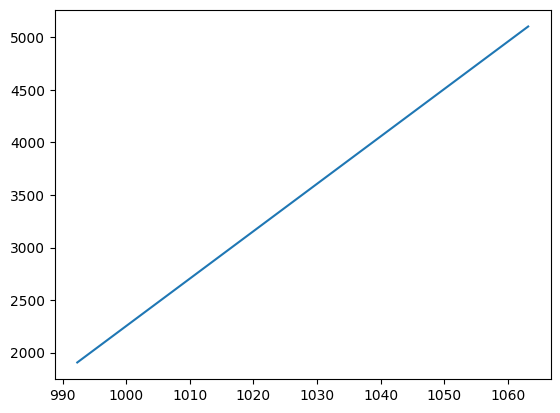

In [81]:
plt.plot(p_inj_valves, valve_depths)